# Digital Image Processing - Assignment 2


## Pre-stuff

In [24]:
# To read and print images
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# To manage arrays and matrices 
import numpy as np

# To deal with path and files
import glob

In [2]:
# Function to plot images

def ploter(img):
    
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')

In [3]:
# All paths to images

# Image of Lena
path1 = '/content/drive/MyDrive/DIP/Lena.png'

# Image consisting all of the numbers
path2 = '/content/drive/MyDrive/DIP/hdraw.png'

# Folder containing images of each number
path3 = '/content/drive/MyDrive/DIP/sub_img/*.png'

# Image of Lena's left eye
path4 = '/content/drive/MyDrive/DIP/left_eye.png'

# Image of a dog
path5 = '/content/drive/MyDrive/DIP/dog.png'

## Question 1

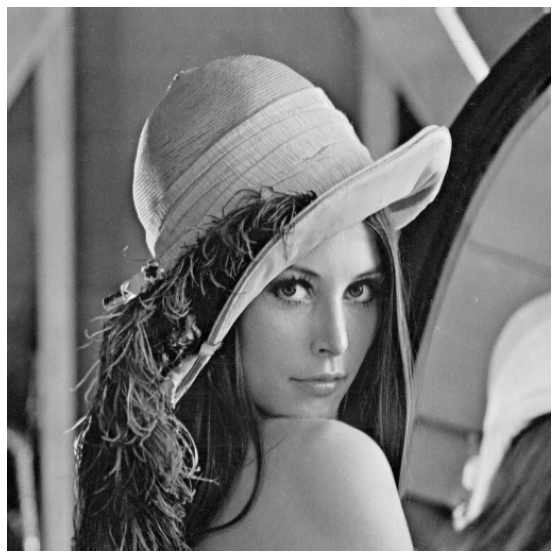

In [4]:
lena = cv.imread(path1)
b, g, r = cv.split(lena)
lena = cv.merge((r, g, b))

gray = (0.3 * r) + (0.59 * g) + (0.11 * b)

ploter(gray)

In [5]:
# A function to add Salt and Pepper noise

def salt_and_pepper(img, perc):
    
    dummy = img.copy()
    amount = int(perc * img.size / 100) 
    
    x_salt, y_salt = [np.random.randint(0, i - 1, amount)
                for i in img.shape]
    dummy[(x_salt,y_salt)] = 255

    x_pepper, y_pepper = [np.random.randint(0, i - 1, amount)
                for i in img.shape]
    dummy[(x_pepper,y_pepper)] = 0
        
    return dummy

0% noise, 50% noise, 100% noise


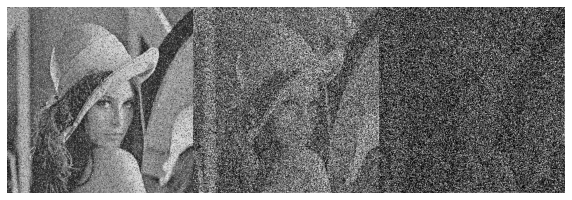

In [6]:
salted_peppered = []

for perc in range(10, 110, 10):
    salted_peppered.append(salt_and_pepper(gray, perc))

print('0% noise, 50% noise, 100% noise')
ploter(np.concatenate((salted_peppered[0], salted_peppered[4], salted_peppered[-1]), axis = 1))

In [7]:
# A function that applies average filter of given size

def avg_filtered(img, n):

    filter = np.ones((n, n)) / (n**2)

    big_img = np.zeros((img.shape[0] + 2*n, img.shape[1] + 2*n))

    big_img[n : img.shape[0] + n, n : img.shape[1] + n ] += img
    dummy_big_img = big_img.copy()

    for x in range(n, img.shape[0] + n):
        for y in range(n, img.shape[1] + n):

            img_portion = dummy_big_img[x-n//2:1+x+n//2, y-n//2:1+y+n//2]
            pix_val = np.sum(np.multiply(img_portion, filter))
            big_img[x, y] = pix_val
    
    return big_img[n : img.shape[0] + n, n : img.shape[1] + n ]


In [8]:
# A function that applies median filter of given size

def med_filtered(img, n):

    big_img = np.ones((img.shape[0] + 2*n, img.shape[1] + 2*n)) * (-1)

    big_img[n : img.shape[0] + n, n : img.shape[1] + n ] += img
    dummy_big_img = big_img.copy()

    for x in range(n, img.shape[0] + n):
        for y in range(n, img.shape[1] + n):

            img_portion = dummy_big_img[x-n//2:1+x+n//2, y-n//2:1+y+n//2]
            vals = np.delete(img_portion.flatten().astype(int), [1])
            big_img[x, y] = np.sort(vals)[len(vals)//2]

    return big_img[n : img.shape[0] + n, n : img.shape[1] + n ]


In [9]:
avg_filtered1 = []

for noisy_img in salted_peppered:
    dum = []
    for filter_size in [3, 5, 7]:
        dum.append(avg_filtered(noisy_img, filter_size))
    avg_filtered1.append(dum)

avg_filtered2 = []

for noisy_img in salted_peppered:
    dum = []
    for filter_size in [3, 5, 7]:
        kernel = np.ones((filter_size,filter_size),np.float32)/(filter_size*filter_size)
        dum.append(cv.filter2D(noisy_img,-1,kernel))
    avg_filtered2.append(dum)


In [10]:
med_filtered1 = []

for noisy_img in salted_peppered:
    dum = []
    for filter_size in [3, 5, 7]:
        dum.append(med_filtered(noisy_img, filter_size))
    med_filtered1.append(dum)

med_filtered2 = []

for noisy_img in salted_peppered:
    dum = []
    for filter_size in [3, 5, 7]:
        dum.append(cv.medianBlur(np.uint8(noisy_img),filter_size))
    med_filtered2.append(dum)

**The following explanation holds for the next two cell's plot :** <br> <br>
The first 3 columns are the outputs of the designed functions. <br>
The last 3 columns are the outputs of in-built functions. <br>
The percentage of noise increases down the plot, where as the filter takes the size of from 3, 5 and 7. <br>

10 levels of noise = 10 rows <br>
3 sizes of designed filter = first 3 columns <br>
3 sizes of inbuilt filter = last 3 columns <br>


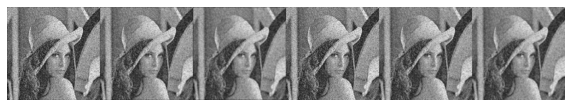

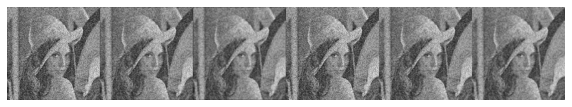

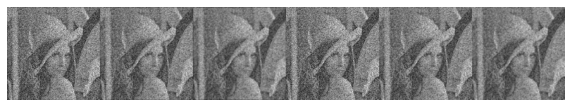

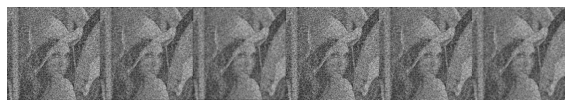

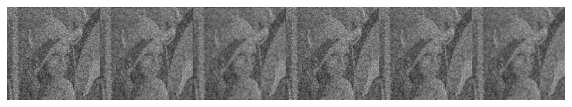

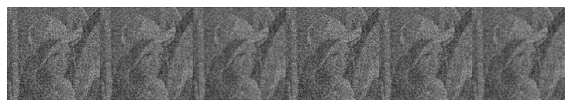

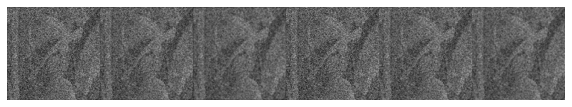

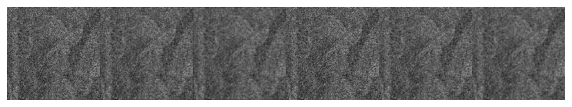

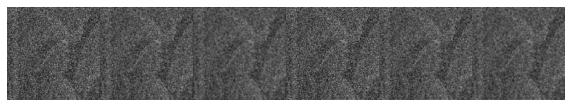

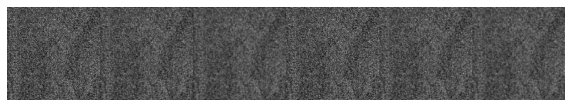

In [11]:
for user, opencv in zip(avg_filtered1, avg_filtered2):
    strip1 = np.concatenate([img for img in user], axis = 1)
    strip2 = np.concatenate([img for img in opencv], axis = 1)
    ploter(np.concatenate([strip1, strip2], axis = 1))

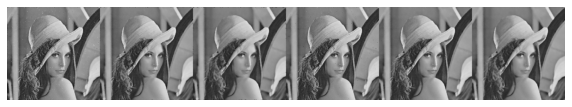

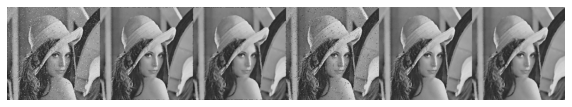

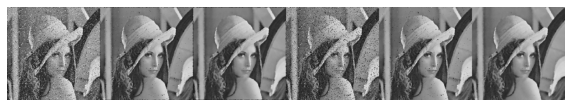

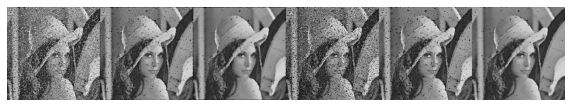

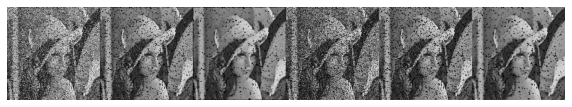

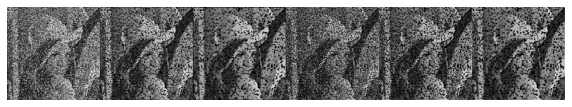

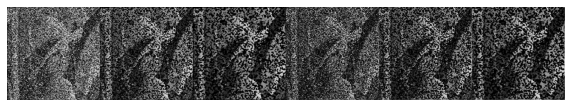

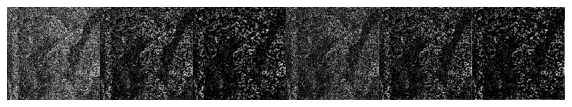

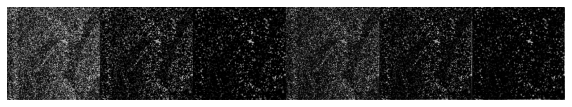

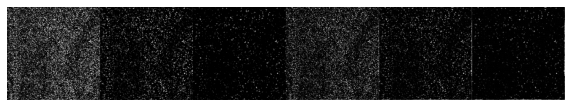

In [12]:
for user, opencv in zip(med_filtered1, med_filtered2):
    strip1 = np.concatenate([img for img in user], axis = 1)
    strip2 = np.concatenate([img for img in opencv], axis = 1)
    ploter(np.concatenate([strip1, strip2], axis = 1))

Median filter clearly out performs averge filter when the noise is of type 'Salt & Pepper'. But it too fails when the noise is very strong.

---

## Question 2

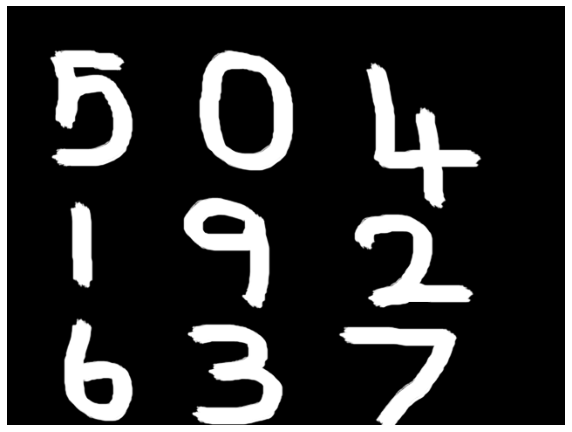

In [13]:
number_plate = cv.imread(path2, 0)
ploter(number_plate)

In [14]:
img_subs = []

for f_name in glob.glob(path3):
    dummy_img = cv.imread(f_name, 0)
    img_subs.append(dummy_img)

In [15]:
# A function which returns the center of the closest matched template
# cross = Fasle -> Simple correllation
# cross = True -> Normalized correlation / Cross-correlation

def correlated(img1, img2, cross = False):

    big_img = np.zeros((img1.shape[0] + 2*img2.shape[0], img1.shape[1] + 2*img2.shape[1]))
    
    n1 = img2.shape[0]
    n2 = img2.shape[1]

    big_img[n1 : img1.shape[0] + n1, n2 : img1.shape[1] + n2] += img1
    dummy_big_img = big_img.copy()
    max_val = 0

    for x in range(n1, img1.shape[0] + n1):
        for y in range(n2, img1.shape[1] + n2):

            img_portion = dummy_big_img[x-int(n1/2) : x-int(n1/2) + n1, y-int(n2/2) : y-int(n2/2) + n2]
            numer = np.sum(np.multiply(img_portion, img2))
            if cross == True:
                denom = np.sqrt(np.sum(img_portion ** 2) * np.sum(img2 ** 2))
            else:
                denom = 1

            big_img[x, y] = numer/denom

            if numer/denom > max_val:
                max_val = numer/denom
                coord = [x-int(3*n1/2), y-int(3*n2/2)]

    return coord

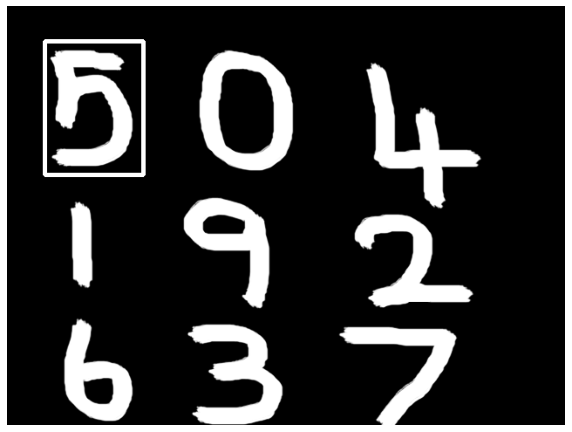

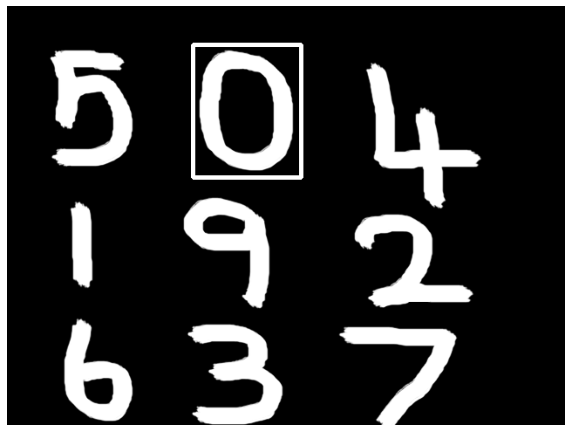

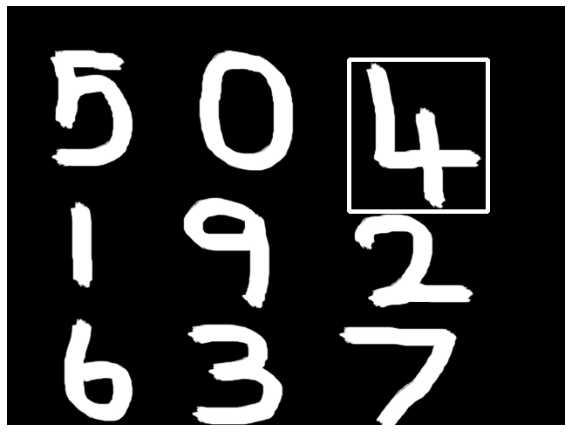

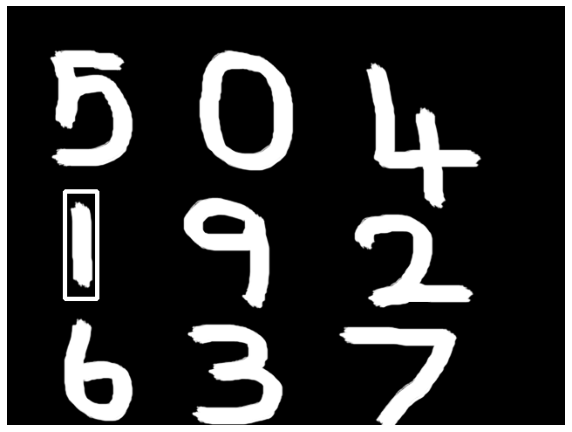

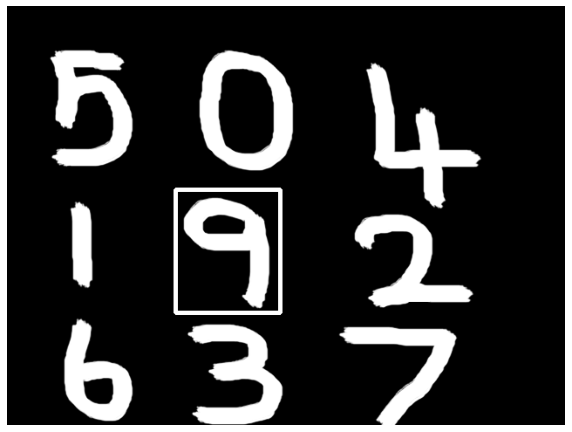

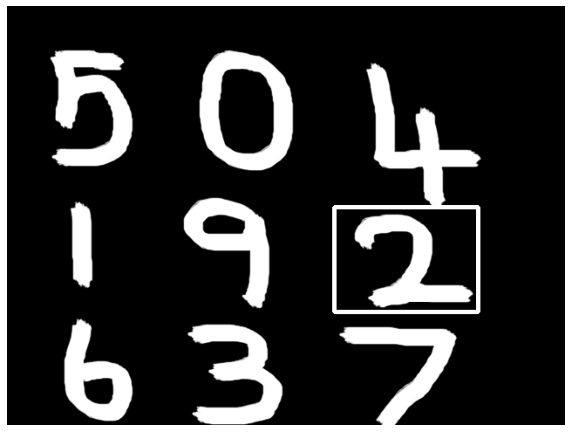

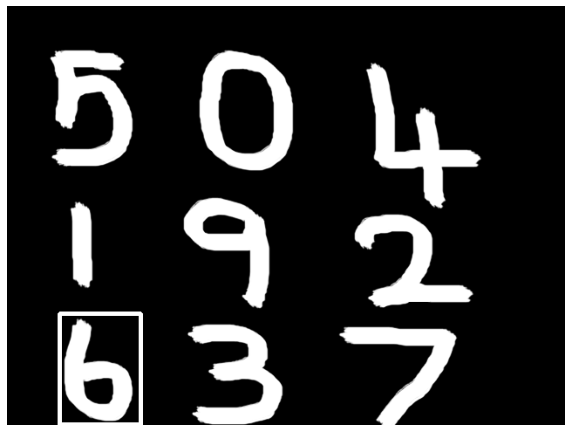

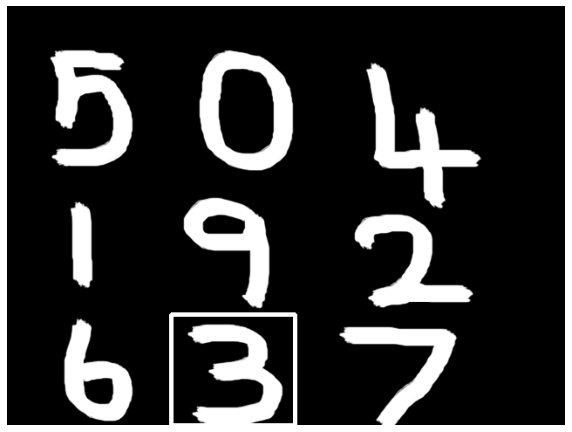

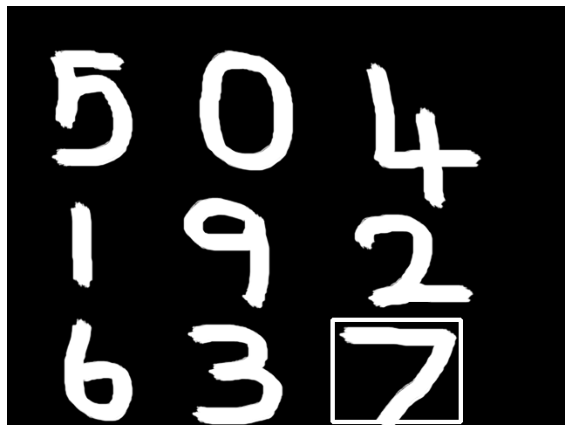

In [16]:
# Using simple correlation

rect = number_plate.copy()

for i, numb in enumerate(img_subs):

    [xx, yy] = correlated(number_plate, numb)
    ploter(cv.rectangle(rect.copy(), (yy, xx), (yy+numb.shape[1], xx+numb.shape[0]), (255, 255, 255), 3))

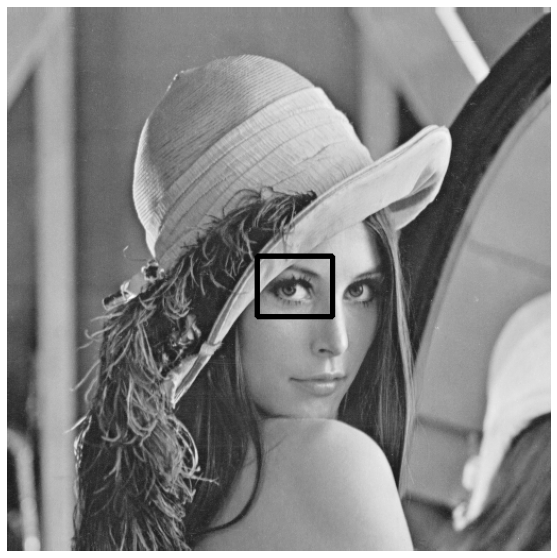

In [17]:
# Using normalized correlation

left_eye = cv.imread(path4)
b, g, r = cv.split(left_eye)

left_eye = (0.3 * r) + (0.59 * g) + (0.11 * b)

[xx, yy] = correlated(gray, left_eye, True)

ploter(cv.rectangle(gray.copy(), (yy, xx), (yy+left_eye.shape[1], xx+left_eye.shape[0]), (0, 160, 0), 3))

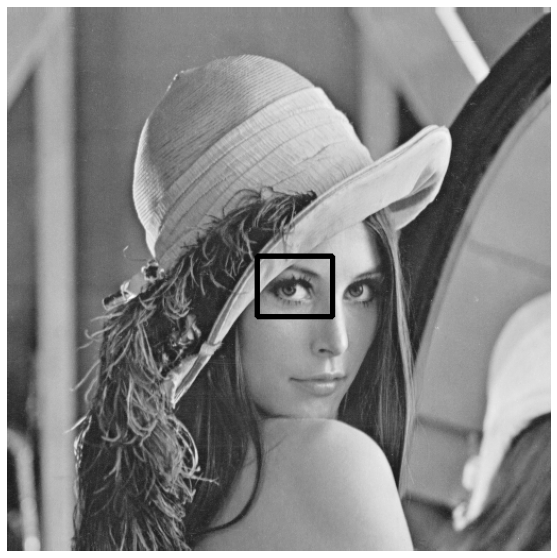

In [18]:
# Using OpenCV's normalized correlation

meth = 'cv.TM_CCORR_NORMED'
opencv_temp = gray.copy()

h = left_eye.shape[1]
w = left_eye.shape[0]

method = eval(meth)
# Apply template Matching
res = cv.matchTemplate(gray.astype(np.uint8),left_eye.astype(np.uint8),method)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

xx = max_loc[1]
yy = max_loc[0]

ploter(cv.rectangle(opencv_temp, (yy, xx), (yy+h, xx+w), (0, 160, 0), 3))



---



## Question 3

In [19]:
# A function which calculates the Discrete Fourier Transform of any signal

def dft(x, N = None):

    if N == None:
        N = max(x.shape)

    X = []
    
    for k in range(int(N)):
        Xk = 0
        for n in range(int(N)):
            try:
                Xk += x[0][n] * np.exp(-2j * np.pi * k * n / N)
            except:
                Xk += x[n] * np.exp(-2j * np.pi * k * n / N)
        X.append(Xk)
    
    return X

In [20]:
sample_input = np.random.random((1, 8))
print('Implemented DFT:', dft(sample_input))
print('-----------------------------------------')
print('Numpy Lib\'s DFT:', np.fft.fft(sample_input)[0])

Implemented DFT: [(3.5149408354038925+0j), (0.16435938927177207-0.5898642456749131j), (0.4002397973853869+0.38862790356174837j), (0.07356703167768452+0.4525361479467561j), (1.356706647641741+1.3667298209178284e-16j), (0.07356703167768425-0.4525361479467566j), (0.4002397973853869-0.3886279035617484j), (0.16435938927177296+0.5898642456749136j)]
-----------------------------------------
Numpy Lib's DFT: [3.51494084+0.j         0.16435939-0.58986425j 0.4002398 +0.3886279j
 0.07356703+0.45253615j 1.35670665+0.j         0.07356703-0.45253615j
 0.4002398 -0.3886279j  0.16435939+0.58986425j]




---



## Question 4

In [21]:
# A function which performs DFT in a faster a way

def fft(x, N = 8, sep = 0):

    if sep == 0:
        x_even = [x[i] for i in range(0, len(x), 2)]
        x_odd = [x[i] for i in range(1, len(x), 2)]

    else:
        x_even = x[0]
        x_odd = x[1]

    G = dft(x_even, N/2)
    G = G + G

    H = dft(x_odd, N/2)
    H = H + H

    F = []
    for k in range(N):
        fk =  G[k] + (np.exp(-2j * np.pi * k / N) * H[k])
        F.append(fk)
    
    return F


# A function which uses the previously defined functions to perform DFT on 2D signals

def dft2d(img):

    sig = np.array(img)

    zeroed = []

    for ind, row in enumerate(sig):
        zeroed.append(fft(row, len(row)))

    ffted = np.stack(zeroed)

    ffteded = []

    for ind, col in enumerate(ffted.T):
        ffteded.append(fft(col, len(col)))

    ffteded = np.stack(ffteded).T

    return ffteded



---



## Question 5

In [ ]:
lena_fft =  dft2d(gray)
lena_fft_plottable = np.fft.fftshift(lena_fft)

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


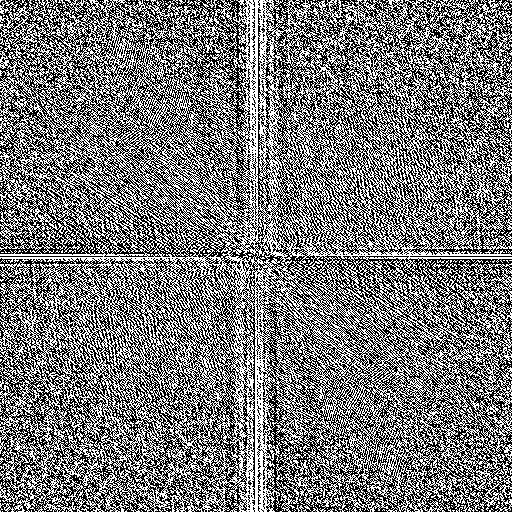

In [25]:
cv2_imshow(lena_fft_plottable)

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


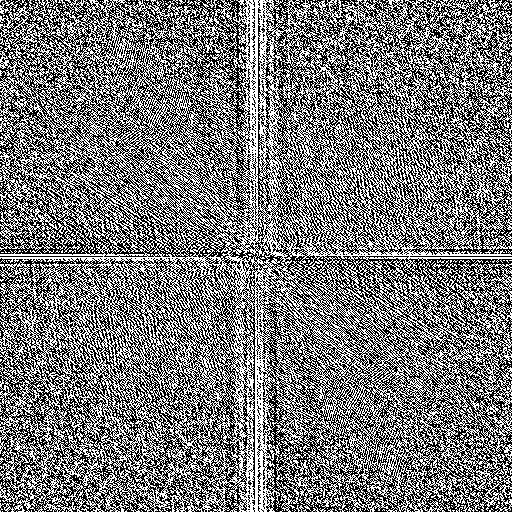

In [28]:
np_lena_fft = np.fft.fft2(gray)
np_lena_fft_plottable = np.fft.fftshift(np_lena_fft)

cv2_imshow(np_lena_fft_plottable)

In [29]:
print('Mean error:', np.mean((lena_fft_plottable - np_lena_fft_plottable)))

Mean error: (1.2341899492854084e-11-3.420974925936331e-12j)


From the error which is tending to zero, it is inferable that the implementation of 2D-DFT is precise. <br>
As a note, in the future numpy's fft package would be used due to its faster computation performance.

In [30]:
lena_mag = np.abs(lena_fft)
lena_ang = np.angle(lena_fft)

Text(0.5, 1.0, 'Rough Frequency Spectrum of DFT of Lena')

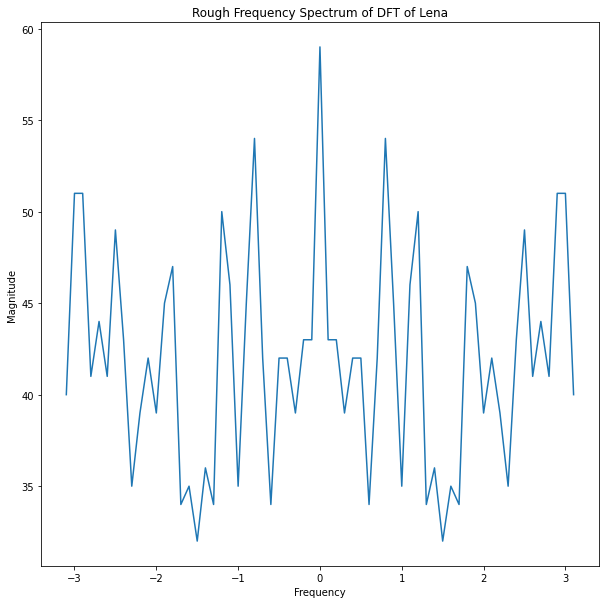

In [33]:
x_axis = np.sort(np.array(list(set(np.round(lena_ang.flatten(),1)))))
y_axis = np.zeros_like(x_axis)

flattened = list(lena_mag.flatten())

for row in lena_ang:
    for val in row:

        val = np.round(val, 3)

        y_axis[x_axis == val] += 1

plt.figure(figsize = (10,10))
plt.plot(x_axis, y_axis)

plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Rough Frequency Spectrum of DFT of Lena')

In [34]:
dog = cv.imread(path5, 0)
dog = cv.resize(dog, (512, 512))

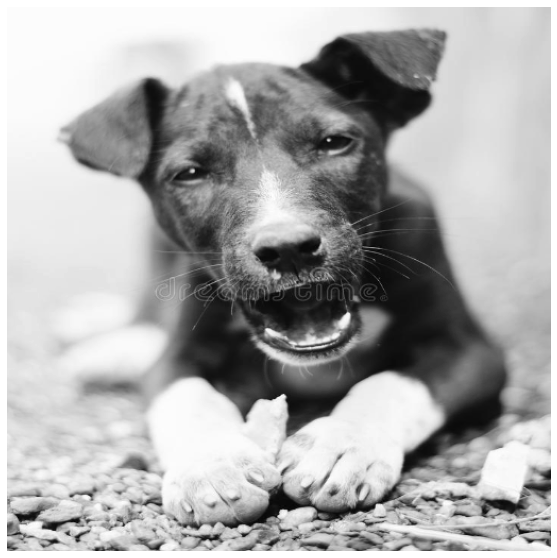

In [35]:
ploter(dog)

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


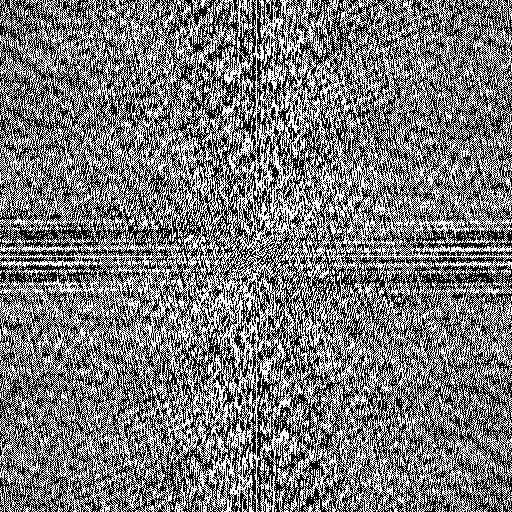

In [36]:
dog_fft = np.fft.fft2(dog)
dog_fft_plottable = np.fft.fftshift(dog_fft)

cv2_imshow(dog_fft_plottable)

In [37]:
dog_mag = np.abs(dog_fft)
dog_ang = np.angle(dog_fft)

Text(0.5, 1.0, 'Rough Frequency Spectrum of DFT of the dog')

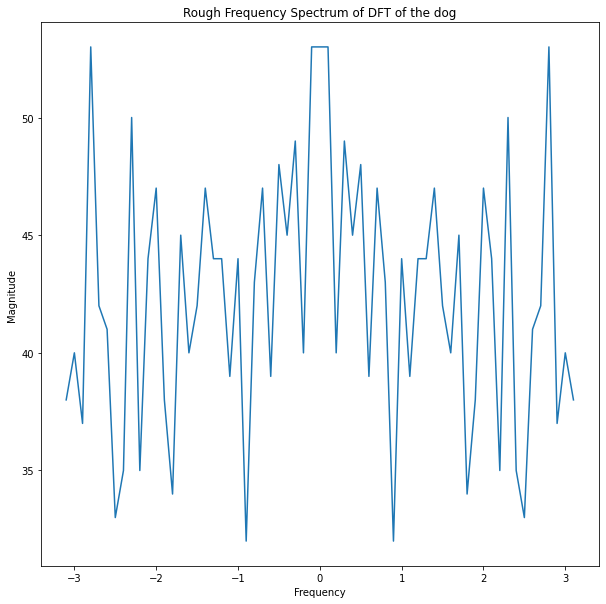

In [38]:
x_axis = np.sort(np.array(list(set(np.round(dog_ang.flatten(),1)))))
y_axis = np.zeros_like(x_axis)

flattened = list(dog_mag.flatten())

for row in dog_ang:
    for val in row:

        val = np.round(val, 3)

        y_axis[x_axis == val] += 1

plt.figure(figsize = (10,10))
plt.plot(x_axis, y_axis)

plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Rough Frequency Spectrum of DFT of the dog')

## Question 6, 7

In [39]:
def inv_dft2d(signal):

    signal = signal.T
    inv_ffted = np.zeros_like(signal)

    for ind in range(len(signal)):

        output = fft(np.conjugate(signal[ind]), len(signal[ind]))

        inv_ffted[ind,:] = np.stack([(r + (1j * i))/len(signal[ind]) for r, i in zip(np.real(output), np.imag(output))])

    inv_ffted = inv_ffted.T
    inv_inv_ffted = np.zeros_like(inv_ffted)

    for ind in range(len(inv_ffted)):

        output = fft(inv_ffted[ind], int(len(signal[ind])))

        inv_inv_ffted[ind,:] = np.stack([(r + (-1j * i))/len(signal[ind]) for r, i in zip(np.real(output), np.imag(output))])

    return np.real(inv_inv_ffted)

In [40]:
lena_inverted = inv_dft2d(dft2d(gray))

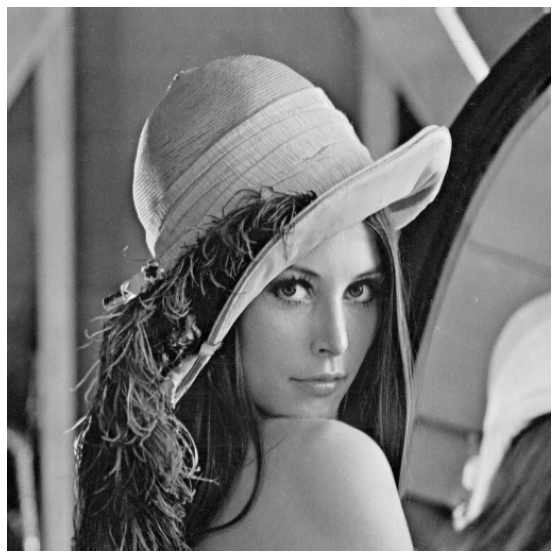

In [41]:
ploter(lena_inverted)

In [47]:
print('Mean inverse DFT error:', np.mean(lena_inverted - np.real(np.fft.ifft2(lena_fft))))

Mean inverse DFT error: 2.003602904247781e-14


From the error which is tending to zero, it is inferable that the implementation of the inverse 2D-DFT is precise. <br>

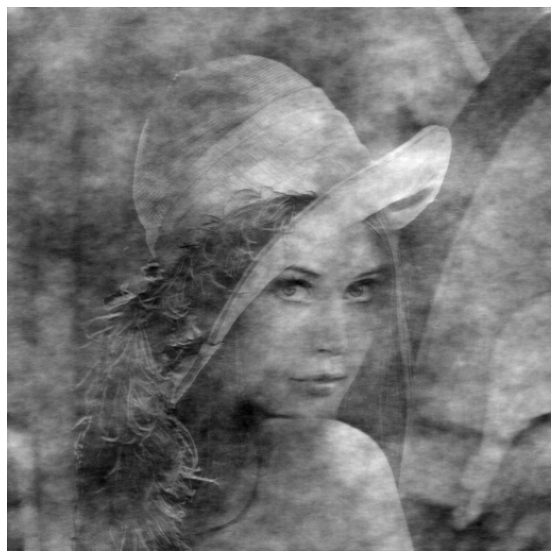

In [48]:
# Lena's magnitude replaced with the dog's magnitude

swapped = np.empty_like(dog_mag, dtype = complex)

for ind in range(len(swapped)):
    swapped[ind] = dog_mag[ind] * np.exp(1j*lena_ang[ind])
    
out = np.fft.ifft2(swapped)
ploter(np.real(out))

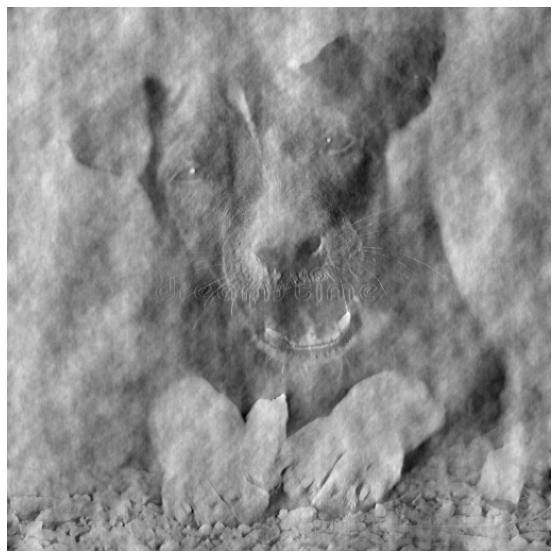

In [49]:
# Dogs's magnitude replaced with Lena's magnitude

swapped = np.empty_like(dog_mag, dtype = complex)

for ind in range(len(swapped)):
    swapped[ind] = lena_mag[ind] * np.exp(1j*dog_ang[ind])

out = np.fft.ifft2(swapped)
ploter(np.real(out))

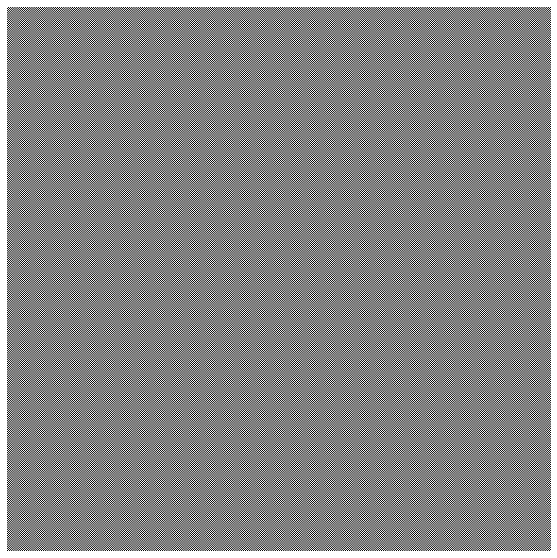

In [50]:
# Lena's magnitude replaced with the dog's phase

swapped = np.empty_like(dog_mag, dtype = complex)

for ind in range(len(swapped)):
    swapped[ind] = dog_ang[ind] * np.exp(1j*lena_ang[ind])

out = np.fft.ifft2(swapped)
ploter(np.real(out))

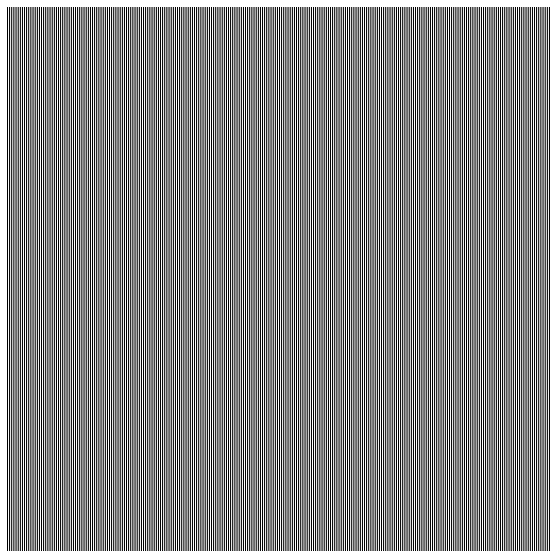

In [51]:
# Dog's magnitude replaced with Lena's phase

swapped = np.empty_like(dog_mag, dtype = complex)

for ind in range(len(swapped)):
    swapped[ind] = lena_ang[ind] * np.exp(1j*dog_ang[ind])

out = np.fft.ifft2(swapped)
ploter(np.real(out))

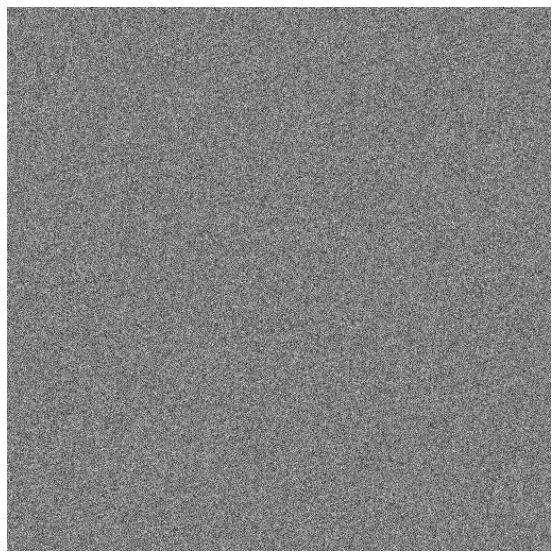

In [52]:
# Total swap 1

swapped = np.empty_like(dog_mag, dtype = complex)

for ind in range(len(swapped)):
    swapped[ind] = lena_ang[ind] * np.exp(1j*dog_mag[ind])

out = np.fft.ifft2(swapped)
ploter(np.real(out))

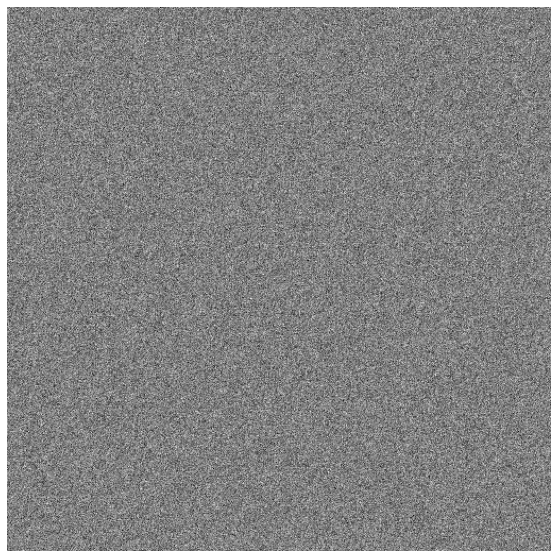

In [53]:
# Total swap 2

swapped = np.empty_like(dog_mag, dtype = complex)

for ind in range(len(swapped)):
    swapped[ind] = dog_ang[ind] * np.exp(1j*lena_mag[ind])

out = np.fft.ifft2(swapped)
ploter(np.real(out))